# Laboratorio 3
## Malware Detection
Universidad del Valle de Guatemala<br>
Security Data Science<br>
Sección 10<br>
Pablo Andrés Zamora Vásquez - 21780<br>
Diego Andrés Morales Aquino - 21762<br>
<br><br>
<hr>

In [1]:
import pandas as pd
import numpy as np

## Modelo 1: ML

### Exploración de datos

In [4]:
# Cargar el dataset
file_path = "MalBehavD-V1-dataset.csv"
df = pd.read_csv(file_path)

# Mostrar el balance de clases en la columna objetivo
class_distribution = df['labels'].value_counts()
print(class_distribution)

labels
0    1285
1    1285
Name: count, dtype: int64


In [5]:
# Mostrar algunas filas de las columnas numéricas para ver cómo están representadas las secuencias
df_numeric_preview = df.iloc[:, 2:20].head()  # Tomar algunas columnas numéricas para inspección
df_numeric_preview

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,LdrUnloadDll,CoUninitialize,NtQueryKey,NtDuplicateObject,GetShortPathNameW,GetSystemInfo,IsDebuggerPresent,GetSystemWindowsDirectoryW,NtClose,GetFileVersionInfoSizeW,NtOpenProcess,GetFileAttributesW,RegQueryValueExW,NtMapViewOfSection,RtlAddVectoredExceptionHandler,GetFileSize,RegOpenKeyExW,SetErrorMode
1,NtOpenMutant,GetForegroundWindow,NtQueryKey,DrawTextExW,NtSetInformationFile,RegQueryValueExA,LdrGetProcedureAddress,CoUninitialize,NtQueryValueKey,RegCloseKey,RegQueryValueExW,NtFreeVirtualMemory,GetSystemMetrics,CreateActCtxW,RegOpenKeyExW,NtReadFile,CreateDirectoryW,NtWriteFile
2,GetForegroundWindow,DrawTextExW,GetSystemInfo,IsDebuggerPresent,GetSystemWindowsDirectoryW,NtQueryValueKey,RegCloseKey,GetFileAttributesW,RegQueryValueExW,NtMapViewOfSection,GetSystemMetrics,RegOpenKeyExW,NtAllocateVirtualMemory,NtWriteFile,LdrGetDllHandle,NtFreeVirtualMemory,FindResourceExA,NtOpenFile
3,NtQueryValueKey,LdrUnloadDll,GlobalMemoryStatus,WriteConsoleA,NtOpenKey,LdrGetProcedureAddress,NtTerminateProcess,NtClose,NtAllocateVirtualMemory,LdrGetDllHandle,GetFileType,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,LdrUnloadDll,GetSystemTimeAsFileTime,NtOpenKey,WSAStartup,SetUnhandledExceptionFilter,NtTerminateProcess,NtClose,NtAllocateVirtualMemory,NtQueryAttributesFile,LdrGetDllHandle,NtQueryValueKey,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Preprocesamiento

Para cada registro, se concatenarán las columnas con las llamadas a las APIs en una sola secuencia. Luego, cada secuencia se convertirán a vectores numéricos usando TF-IDF:

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Concatenar todas las columnas numéricas en una sola secuencia por fila
df["api_sequence"] = df.iloc[:, 2:].astype(str).apply(lambda row: ' '.join(row.dropna()), axis=1)

# Aplicar TF-IDF para vectorizar las secuencias
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(df["api_sequence"])

# Mostrar la dimensión del nuevo conjunto de características
X_tfidf.shape

(2570, 292)

### Implementación

Se implementará un modelo de Random Forest para clasificar cada secuencia de llamadas a APIs como maligna o benigna:

In [8]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

# Definir las etiquetas de la clasificación
y = df["labels"].astype(int)

# Definir el modelo de Random Forest con 100 árboles
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Dividir el conjunto de datos en 70% entrenamiento y 30% pruebas
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.30, random_state=42, stratify=y)

# Realizar validación cruzada en el conjunto de entrenamiento
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=10, scoring="accuracy")

# Entrenar el modelo en todo el conjunto de entrenamiento
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

### Validación

In [10]:
# Evaluar en el conjunto de prueba
y_pred_test = rf_model.predict(X_test)

# Calcular métricas en el conjunto de prueba
accuracy_test = accuracy_score(y_test, y_pred_test)
precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
roc_auc_test = roc_auc_score(y_test, y_pred_test)

# Mostrar los resultados
print('Cross-validation Accuracy: ', cv_scores.mean())
print('Accuracy: ', accuracy_test)
print('Precision: ', precision_test)
print('Recall: ', recall_test)
print('ROC AUC: ', roc_auc_test)

Cross-validation Accuracy:  0.963314711359404
Accuracy:  0.9649805447470817
Precision:  0.9890710382513661
Recall:  0.9402597402597402
ROC AUC:  0.964948522979611


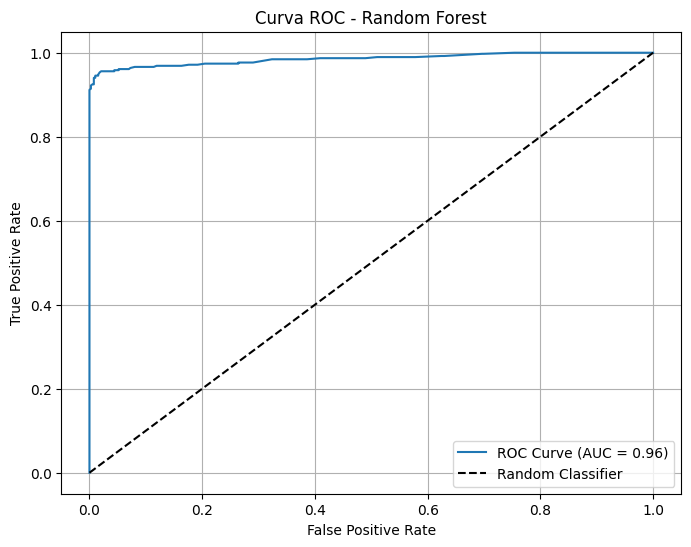

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# Obtener la curva ROC
fpr, tpr, _ = roc_curve(y_test, rf_model.predict_proba(X_test)[:, 1])

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc_test:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC - Random Forest")
plt.legend()
plt.grid()
plt.show()

La curva ROC muestra que el modelo tiene un muy buen desempeño, con un Área Bajo la Curva (AUC) de 96.50%, lo que indica una alta capacidad de discriminación entre malware y archivos benignos.

## Modelo 2: DL

## Comparación de modelos